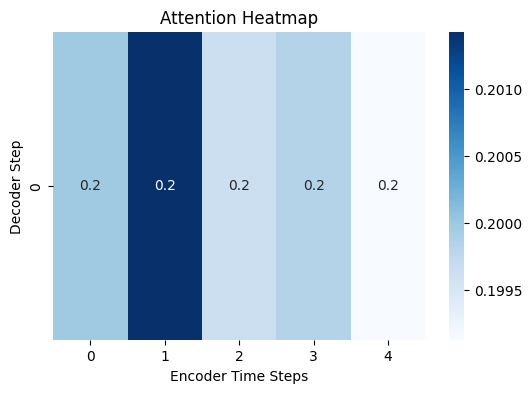

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# Encoder: Processes input sequences using GRU
# ==========================================
class Encoder(nn.Module):
    """
    Encoder: Uses an RNN (GRU) to process input sequences and generate hidden states.
    Formula:
        h_t = RNN(h_{t-1}, x_t)
    """
    def __init__(self, input_dim, embedding_dim, hidden_dim, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)  # Converts token indices to embedding vectors
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)  # GRU for sequence modeling

    def forward(self, x):
        embedded = self.embedding(x)                      # Shape: (batch_size, seq_len, embedding_dim)
        outputs, hidden = self.rnn(embedded)              # outputs: All hidden states; hidden: Final hidden state
        return outputs, hidden

# ==========================================
# Attention: Computes context vector from encoder outputs
# ==========================================
class Attention(nn.Module):
    """
    Attention mechanism: Computes alignment scores and generates context vector.
    Formula:
        e_{ij} = v^T tanh(W [s_i; h_j])
        α_{ij} = softmax(e_{ij})
        c_t = Σ α_{ij} * h_j
    """
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)  # Linear layer for computing energy scores
        self.v = nn.Linear(hidden_dim, 1, bias=False)      # Final projection to scalar energy

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.shape[1]                 # Length of encoder sequence
        hidden = hidden[-1].unsqueeze(1).repeat(1, seq_len, 1)  # Repeat decoder hidden for each encoder step
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # Concatenate and pass through tanh
        attention = torch.softmax(self.v(energy).squeeze(2), dim=1)  # Softmax over time dimension
        context = torch.bmm(attention.unsqueeze(1), encoder_outputs).squeeze(1)  # Weighted sum to get context vector
        return context, attention

# ==========================================
# Decoder: Generates output tokens using GRU and attention
# ==========================================
class Decoder(nn.Module):
    """
    Decoder: Uses GRU and attention to generate output sequence.
    Formula:
        s_t = RNN(s_{t-1}, [e(y_{t-1}), c_t])
        ℓ_t = softmax(W s_t + b)
    """
    def __init__(self, output_dim, embedding_dim, hidden_dim, num_layers):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, embedding_dim)  # Token embedding
        self.rnn = nn.GRU(embedding_dim + hidden_dim, hidden_dim, num_layers, batch_first=True)  # GRU with context + embedding
        self.fc = nn.Linear(hidden_dim, output_dim)  # Final prediction layer
        self.attention = Attention(hidden_dim)       # Attention module

    def forward(self, x, hidden, encoder_outputs):
        x = x.unsqueeze(1)                           # Shape: (batch, 1) — single time step
        embedded = self.embedding(x)                 # Shape: (batch, 1, embed_dim)
        context, attention_weights = self.attention(hidden, encoder_outputs)  # Get context vector
        rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)       # Combine context and embedding
        output, hidden = self.rnn(rnn_input, hidden)  # Pass through GRU
        prediction = self.fc(output.squeeze(1))       # Final token prediction
        return prediction, hidden, attention_weights

# ==========================================
# Setup: Define model parameters and initialize models
# ==========================================
input_dim = output_dim = 10         # Vocabulary size (10 words)
embedding_dim = 16                  # Size of word embeddings
hidden_dim = 32                     # Size of GRU hidden states
num_layers = 1                      # Single-layer GRU
encoder = Encoder(input_dim, embedding_dim, hidden_dim, num_layers)
decoder = Decoder(output_dim, embedding_dim, hidden_dim, num_layers)

# ==========================================
# Utility: Generate random training data
# ==========================================
def generate_data(batch_size=1, seq_length=5):
    return torch.randint(0, input_dim, (batch_size, seq_length))  # Random int sequences of given length

data = generate_data()                           # Input sequence for encoder
encoder_outputs, hidden = encoder(data)          # Encoder output
target = generate_data()                         # Target output sequence

# ==========================================
# Inference: Visualize attention for a single decoding step
# ==========================================
with torch.no_grad():
    test_word = target[0, 0].unsqueeze(0)         # Single token (batch of 1)
    predictions, hidden, attn_weights = decoder(test_word, hidden, encoder_outputs)  # One decoding step
    attn_weights = attn_weights.squeeze().numpy()  # Attention weights for visualization

    # Plot attention heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(attn_weights.reshape(1, -1), cmap='Blues', annot=True)
    plt.xlabel("Encoder Time Steps")
    plt.ylabel("Decoder Step")
    plt.title("Attention Heatmap")
    plt.show()

###  **Summary of the Code**

This code implements a simple **Seq2Seq (Sequence-to-Sequence) model with Attention** using PyTorch. It's structured into three main components:

---

### **1. Encoder**  
- Takes a sequence of token indices (e.g., words).
- Embeds them into vectors.
- Passes them through a **GRU** to get encoder outputs and a final hidden state.

---

###  **2. Attention Mechanism**  
- Computes **attention weights** between decoder hidden state and each encoder output.
- Produces a **context vector**: a weighted sum of encoder outputs.
- Helps the decoder focus on relevant parts of the input sequence.

---

###  **3. Decoder**  
- Takes the previous output token and context vector.
- Embeds the token and concatenates with context.
- Uses another **GRU** and a **linear layer** to predict the next token.
- Attention is applied at each step.

---

###  **4. Inference & Visualization**  
- Generates a random test input and target sequence.
- Runs **one step of decoding** using the trained encoder and decoder.
- Plots an **attention heatmap** showing how much the decoder "attended" to each input token at that step.

---

This code is useful for demonstrating how attention works in **Neural Machine Translation (NMT)** or **image captioning** scenarios, and it's easily extendable to multi-step decoding for full sequence generation.